# Trader Behavior Insights: BTC Market Sentiment vs. Trader Performance

This notebook explores the relationship between trader performance on Hyperliquid and Bitcoin market sentiment (Fear/Greed index).

## Analysis Goals
1. Understand trader behavior patterns
2. Analyze how market sentiment affects trading performance
3. Identify correlations between sentiment and PnL, leverage, positioning
4. Deliver actionable insights for trading strategies

In [1]:
# Import libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Import project modules
sys.path.append('..')
from src.trader_sentiment.data_loader import load_trades, load_fear_greed, daily_trader_agg, align_with_sentiment
from src.trader_sentiment.analysis import build_daily_join

## 1. Data Loading and Initial Exploration

In [2]:
# Load raw data
trades_raw = load_trades('../data/raw/hyperliquid_trades.csv')
sentiment_raw = load_fear_greed('../data/raw/fear_greed.csv')

print(f"Total trades: {len(trades_raw):,}")
print(f"Date range: {trades_raw['date'].min()} to {trades_raw['date'].max()}")
print(f"\nUnique accounts: {trades_raw['account'].nunique()}")
print(f"\nSentiment records: {len(sentiment_raw)}")
print(f"Sentiment date range: {sentiment_raw['date'].min()} to {sentiment_raw['date'].max()}")

Total trades: 211,224
Date range: 2023-03-28 to 2025-06-15

Unique accounts: 32

Sentiment records: 2644
Sentiment date range: 2018-02-01 to 2025-05-02


In [3]:
# Display sample trades
print("Sample trades:")
trades_raw[['account', 'coin', 'side', 'size usd', 'closed pnl', 'date']].head(10)

Sample trades:


,account,coin,side,size usd,closed pnl,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,7872.16,0.0,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,127.68,0.0,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,1150.63,0.0,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,1142.04,0.0,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,69.75,0.0,2024-10-27
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,11.27,0.0,2024-10-27
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,1151.77,0.0,2024-10-27
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,272.00,0.0,2024-10-27
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,368.00,0.0,2024-10-27
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,100.00,0.0,2024-10-27


In [4]:
# Display sentiment data
print("Sentiment distribution:")
print(sentiment_raw['classification'].value_counts())
sentiment_raw.head(10)

Sentiment distribution:
classification
fear             781
greed            633
extreme fear     508
neutral          396
extreme greed    326
Name: count, dtype: int64


,timestamp,value,classification,date
0,1517463000,30,fear,2018-02-01
1,1517549400,15,extreme fear,2018-02-02
2,1517635800,40,fear,2018-02-03
3,1517722200,24,extreme fear,2018-02-04
4,1517808600,11,extreme fear,2018-02-05
5,1517895000,8,extreme fear,2018-02-06
6,1517981400,36,fear,2018-02-07
7,1518067800,30,fear,2018-02-08
8,1518154200,44,fear,2018-02-09
9,1518240600,54,neutral,2018-02-10


## 2. Data Aggregation: Daily Trader Metrics

In [5]:
# Aggregate trades by account and day
daily_agg = daily_trader_agg(trades_raw)

print(f"Total account-day records: {len(daily_agg)}")
print(f"\nColumns: {daily_agg.columns.tolist()}")
print("\nSample aggregated data:")
daily_agg.head(10)

Total account-day records: 102

Columns: ['account', 'date', 'trades', 'total_pnl', 'avg_pnl_per_trade', 'winning_trades', 'losing_trades', 'volume_usd', 'long_bias', 'total_fees']

Sample aggregated data:


,account,date,trades,total_pnl,avg_pnl_per_trade,winning_trades,losing_trades,volume_usd,long_bias,total_fees
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,462,-3.275059e+05,-708.887230,12,127,6842632.02,0.300866,1112.895650
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,3356,1.927736e+06,574.414696,1361,232,54854631.95,0.468415,6292.416654
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,320,2.060745e+04,64.398269,170,0,797679.97,0.453125,202.167151
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,3533,1.709873e+04,4.839719,1537,390,5982611.50,0.432494,1664.914670
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,3427,1.017915e+04,2.970279,1516,553,5255196.19,0.403268,862.756068
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,5,-1.000000e+00,-0.200000,0,2,30351.00,0.400000,10.197932
6,0x271b280974205ca63b716753467d5a371de622ab,2024-10-27,5,1.793160e+03,358.632043,4,0,159708.30,0.600000,34.662051
7,0x271b280974205ca63b716753467d5a371de622ab,2025-02-19,1136,2.997093e+04,26.382859,489,48,12310719.50,0.445423,3644.197056
8,0x271b280974205ca63b716753467d5a371de622ab,2025-06-15,2663,-1.021993e+05,-38.377499,657,407,21372661.62,0.396170,5591.925811
9,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2024-10-27,6472,1.218804e+05,18.831951,2872,590,3129795.22,0.476823,1079.296793


In [6]:
# Summary statistics
print("Daily aggregation statistics:")
daily_agg.describe()

Daily aggregation statistics:


,trades,total_pnl,avg_pnl_per_trade,winning_trades,losing_trades,volume_usd,long_bias,total_fees
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,1.020000e+02,102.000000,102.000000
mean,2070.823529,1.009506e+05,113.190016,851.656863,171.950980,1.167831e+07,0.476368,2410.369809
std,3796.503132,2.826451e+05,446.218405,1639.190234,441.841564,3.332521e+07,0.238377,6638.280306
min,2.000000,-3.639249e+05,-715.304266,0.000000,0.000000,1.404000e+01,0.000000,0.000000
25%,157.750000,1.265832e+02,1.826180,36.500000,0.000000,4.117880e+05,0.397062,59.104666
50%,548.500000,1.848526e+04,20.496457,206.500000,32.500000,2.090509e+06,0.471358,358.959289
75%,3052.250000,9.994411e+04,74.587027,881.250000,171.750000,6.886166e+06,0.586185,1326.181208
max,26651.000000,1.927736e+06,3731.407398,10257.000000,3769.000000,2.566344e+08,1.000000,48255.532024


## 3. Join with Market Sentiment

In [7]:
# Join trader data with sentiment
df = align_with_sentiment(daily_agg, sentiment_raw)

print(f"Total records: {len(df)}")
print(f"Records with sentiment: {df['classification'].notna().sum()}")
print(f"Records without sentiment: {df['classification'].isna().sum()}")
print("\nSentiment distribution in joined data:")
print(df['classification'].value_counts())

Total records: 102
Records with sentiment: 77
Records without sentiment: 25

Sentiment distribution in joined data:
classification
greed            32
fear             32
neutral           8
extreme greed     5
Name: count, dtype: int64


In [8]:
# Calculate win rate
df['win_rate'] = df['winning_trades'] / (df['winning_trades'] + df['losing_trades'])
df['net_pnl'] = df['total_pnl'] - df['total_fees']

# Filter to records with sentiment for analysis
df_with_sentiment = df[df['classification'].notna()].copy()

print(f"\nRecords with sentiment for analysis: {len(df_with_sentiment)}")
df_with_sentiment.head()


Records with sentiment for analysis: 77


,account,date,trades,total_pnl,avg_pnl_per_trade,winning_trades,losing_trades,volume_usd,long_bias,total_fees,classification,win_rate,net_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,462,-3.275059e+05,-708.887230,12,127,6842632.02,0.300866,1112.895650,greed,0.086331,-3.286188e+05
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,3356,1.927736e+06,574.414696,1361,232,54854631.95,0.468415,6292.416654,fear,0.854363,1.921443e+06
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,320,2.060745e+04,64.398269,170,0,797679.97,0.453125,202.167151,greed,1.000000,2.040528e+04
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,3533,1.709873e+04,4.839719,1537,390,5982611.50,0.432494,1664.914670,fear,0.797613,1.543381e+04
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,5,-1.000000e+00,-0.200000,0,2,30351.00,0.400000,10.197932,neutral,0.000000,-1.119793e+01


## 4. Exploratory Data Analysis

### 4.1 Trading Activity by Sentiment

In [9]:
# Group by sentiment
sentiment_groups = df_with_sentiment.groupby('classification').agg({
    'trades': ['count', 'mean', 'sum'],
    'total_pnl': ['mean', 'sum', 'std'],
    'net_pnl': ['mean', 'sum'],
    'volume_usd': ['mean', 'sum'],
    'long_bias': 'mean',
    'win_rate': 'mean',
    'winning_trades': 'sum',
    'losing_trades': 'sum'
})

print("Performance by Market Sentiment:")
sentiment_groups

Performance by Market Sentiment:


trades                          total_pnl                \
                count        mean     sum           mean           sum   
classification                                                           
extreme greed       5  1392.40000    6962   35393.098355  1.769655e+05   
fear               32  4183.46875  133871  209372.662205  6.699925e+06   
greed              32  1134.03125   36289   99675.516731  3.189617e+06   
neutral             8   892.62500    7141   19842.797260  1.587424e+05   

                                     net_pnl                  volume_usd  \
                          std           mean           sum          mean   
classification                                                             
extreme greed    85325.499902   34030.542108  1.701527e+05  7.881354e+06   
fear            380423.906864  204840.848342  6.554907e+06  2.200495e+07   
greed           282694.285526   98915.078187  3.165283e+06  3.609490e+06   
neutral          57227.787895   18749.812574  1.499985e+05  2.730404e+06   

                             long_bias  win_rate winning_trades losing_trades  
                         sum      mean      mean            sum           sum  
classification                                                                 
extreme greed   3.940677e+07  0.518479  0.672283           3412           920  
fear            7.041585e+08  0.459352  0.869433          55576          8960  
greed           1.155037e+08  0.495780  0.871128          16202          2873  
neutral         2.184323e+07  0.468967  0.530949           2265           547

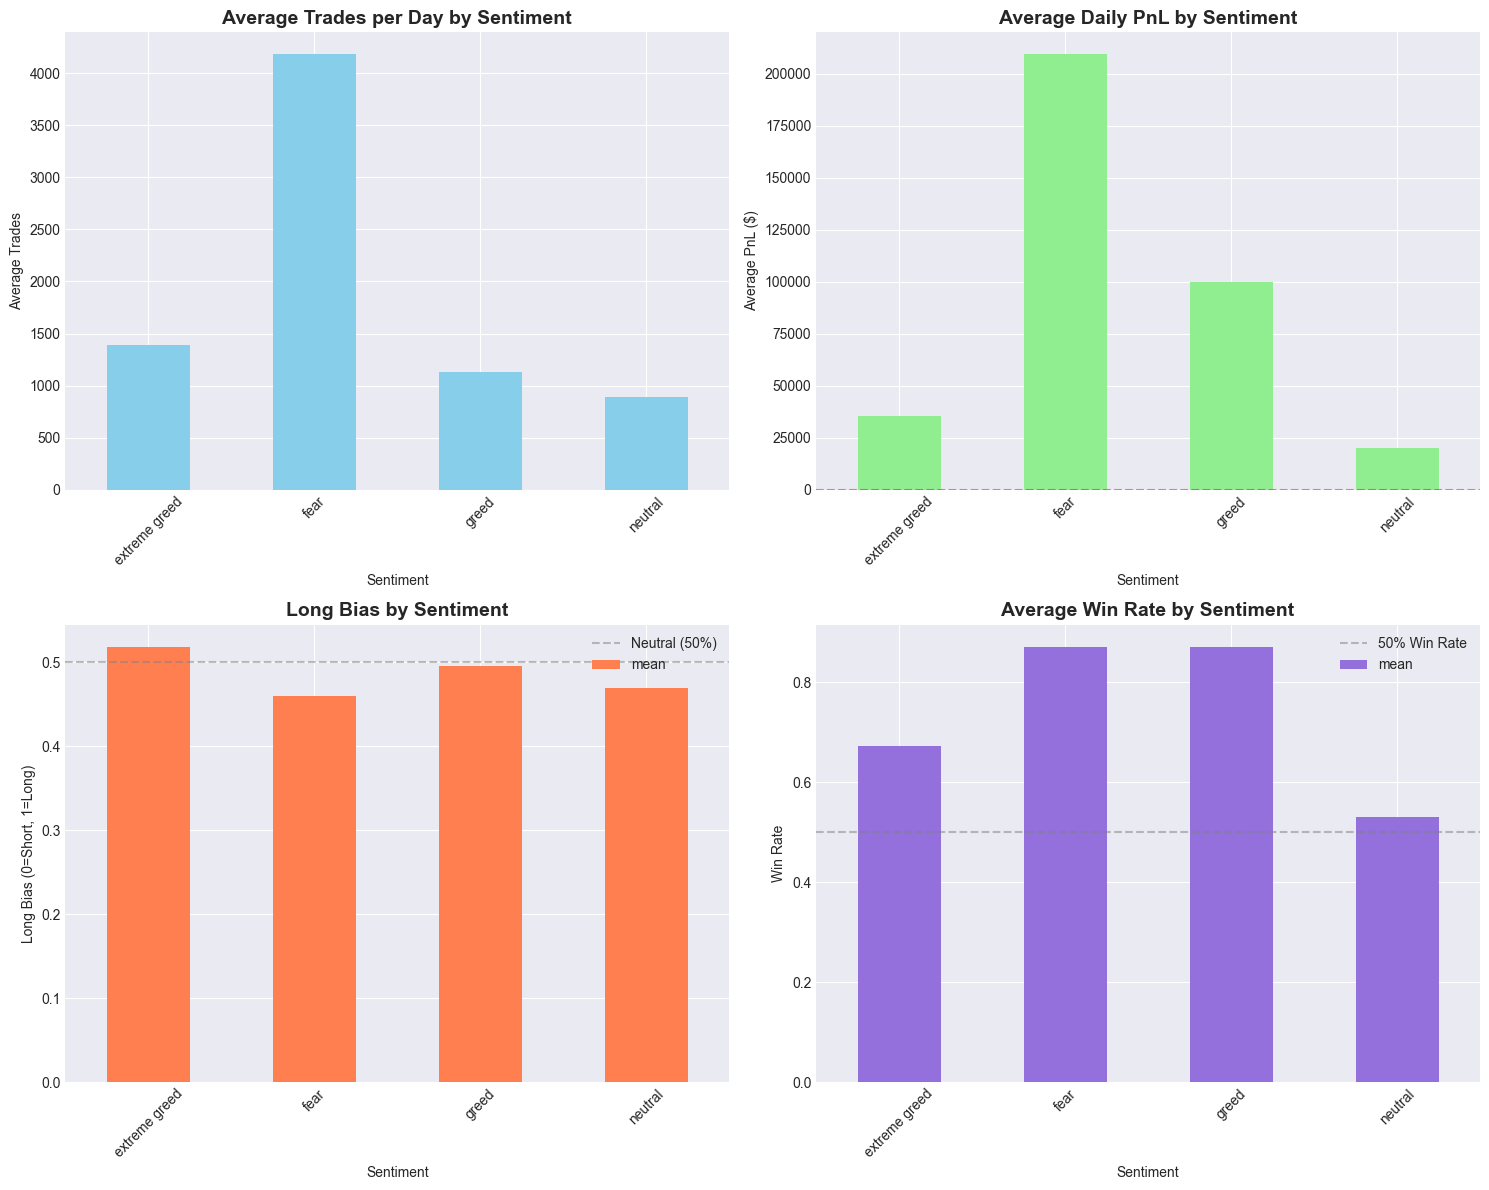

In [10]:
# Visualize trading volume by sentiment
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average trades per day by sentiment
sentiment_groups['trades']['mean'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Average Trades per Day by Sentiment', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average Trades')
axes[0, 0].set_xlabel('Sentiment')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average PnL by sentiment
sentiment_groups['total_pnl']['mean'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Average Daily PnL by Sentiment', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Average PnL ($)')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# 3. Long bias by sentiment
sentiment_groups['long_bias']['mean'].plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Long Bias by Sentiment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Long Bias (0=Short, 1=Long)')
axes[1, 0].set_xlabel('Sentiment')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral (50%)')
axes[1, 0].legend()

# 4. Win rate by sentiment
sentiment_groups['win_rate']['mean'].plot(kind='bar', ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('Average Win Rate by Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Win Rate')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/processed/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 PnL Distribution Analysis

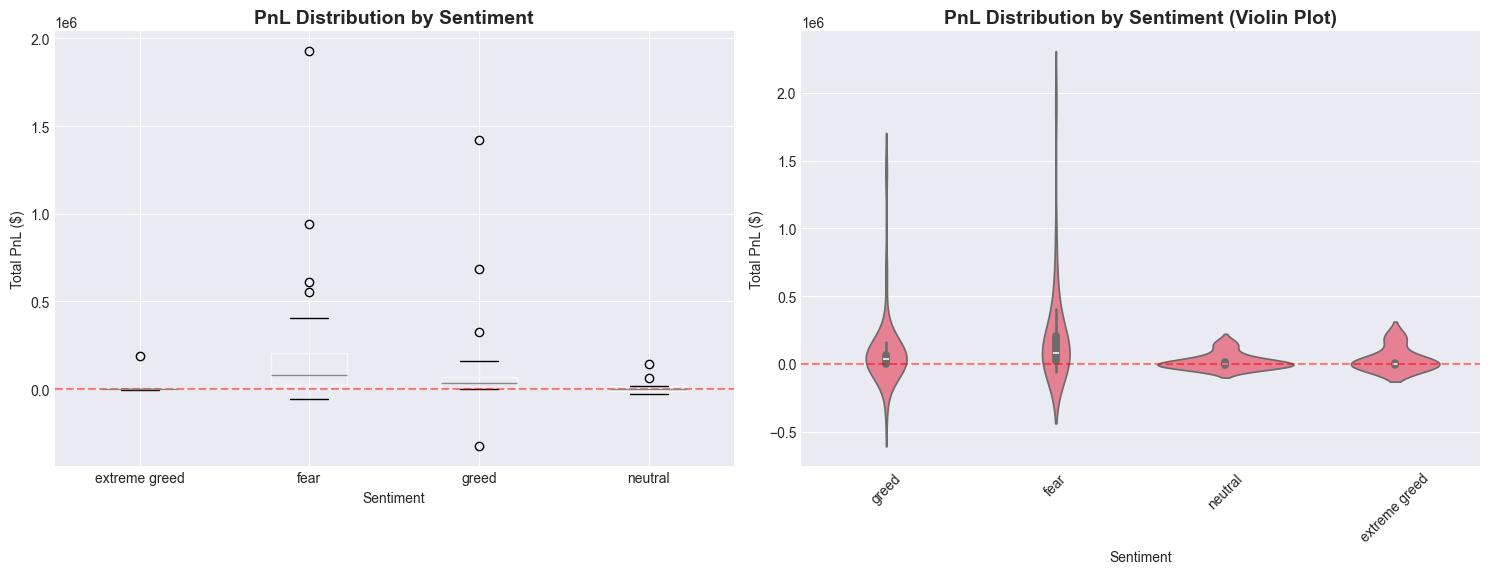

In [11]:
# Box plot of PnL by sentiment
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
df_with_sentiment.boxplot(column='total_pnl', by='classification', ax=axes[0])
axes[0].set_title('PnL Distribution by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Total PnL ($)')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.suptitle('')  # Remove automatic title

# Violin plot
sns.violinplot(data=df_with_sentiment, x='classification', y='total_pnl', ax=axes[1])
axes[1].set_title('PnL Distribution by Sentiment (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Total PnL ($)')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/pnl_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Correlation Analysis

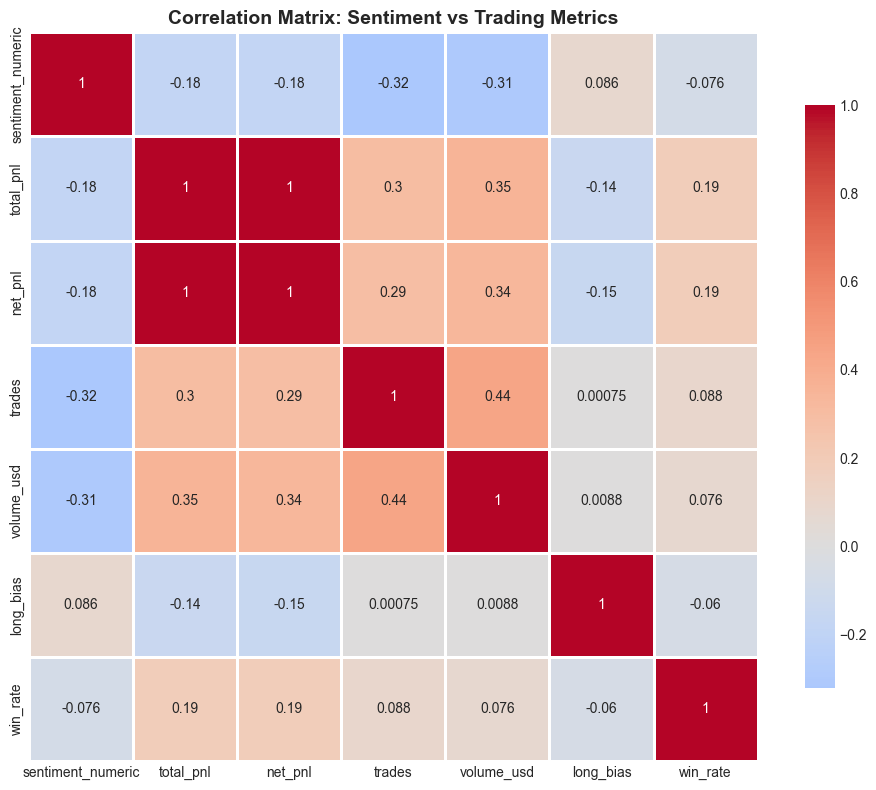


Correlations with Sentiment:
sentiment_numeric    1.000000
long_bias            0.085746
win_rate            -0.075792
net_pnl             -0.176761
total_pnl           -0.181416
volume_usd          -0.308303
trades              -0.320980
Name: sentiment_numeric, dtype: float64


In [12]:
# Create numeric encoding for sentiment
sentiment_order = ['extreme fear', 'fear', 'neutral', 'greed', 'extreme greed']
df_with_sentiment['sentiment_numeric'] = df_with_sentiment['classification'].map(
    {s: i for i, s in enumerate(sentiment_order)}
)

# Calculate correlations
corr_cols = ['sentiment_numeric', 'total_pnl', 'net_pnl', 'trades', 'volume_usd', 'long_bias', 'win_rate']
correlation_matrix = df_with_sentiment[corr_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Sentiment vs Trading Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/processed/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelations with Sentiment:")
print(correlation_matrix['sentiment_numeric'].sort_values(ascending=False))

### 4.4 Long/Short Bias Analysis

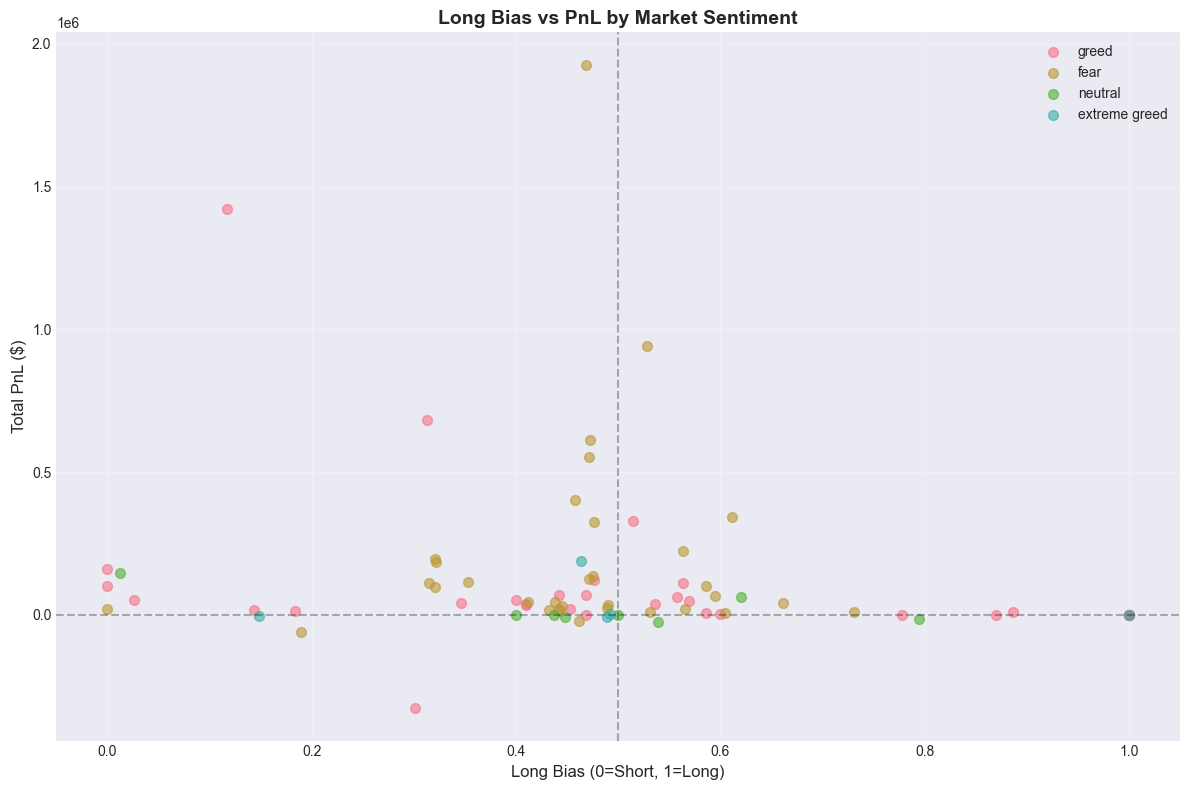

In [13]:
# Scatter plot: Long bias vs PnL by sentiment
plt.figure(figsize=(12, 8))
for sentiment in df_with_sentiment['classification'].unique():
    subset = df_with_sentiment[df_with_sentiment['classification'] == sentiment]
    plt.scatter(subset['long_bias'], subset['total_pnl'], 
                label=sentiment, alpha=0.6, s=50)

plt.xlabel('Long Bias (0=Short, 1=Long)', fontsize=12)
plt.ylabel('Total PnL ($)', fontsize=12)
plt.title('Long Bias vs PnL by Market Sentiment', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/long_bias_vs_pnl.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Volume Analysis

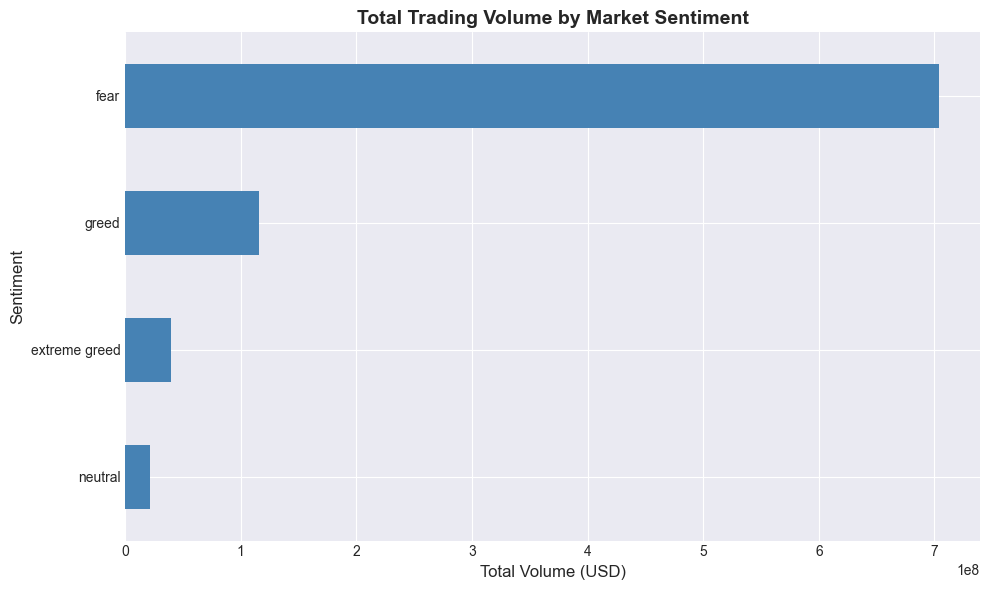

Total volume by sentiment:
classification
neutral          2.184323e+07
extreme greed    3.940677e+07
greed            1.155037e+08
fear             7.041585e+08
Name: volume_usd, dtype: float64


In [14]:
# Total volume by sentiment
volume_by_sentiment = df_with_sentiment.groupby('classification')['volume_usd'].sum().sort_values()

plt.figure(figsize=(10, 6))
volume_by_sentiment.plot(kind='barh', color='steelblue')
plt.title('Total Trading Volume by Market Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Total Volume (USD)', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.tight_layout()
plt.savefig('../data/processed/volume_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Total volume by sentiment:")
print(volume_by_sentiment)

## 5. Key Insights and Statistical Tests

In [15]:
# Statistical comparison: Fear vs Greed
from scipy import stats

fear_pnl = df_with_sentiment[df_with_sentiment['classification'] == 'fear']['total_pnl'].dropna()
greed_pnl = df_with_sentiment[df_with_sentiment['classification'] == 'greed']['total_pnl'].dropna()

# T-test
t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl)

print("="*60)
print("STATISTICAL COMPARISON: FEAR vs GREED")
print("="*60)
print(f"\nFear periods:")
print(f"  Mean PnL: ${fear_pnl.mean():.2f}")
print(f"  Median PnL: ${fear_pnl.median():.2f}")
print(f"  Std Dev: ${fear_pnl.std():.2f}")
print(f"  Count: {len(fear_pnl)}")

print(f"\nGreed periods:")
print(f"  Mean PnL: ${greed_pnl.mean():.2f}")
print(f"  Median PnL: ${greed_pnl.median():.2f}")
print(f"  Std Dev: ${greed_pnl.std():.2f}")
print(f"  Count: {len(greed_pnl)}")

print(f"\nT-test Results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Statistically significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")
print("="*60)

STATISTICAL COMPARISON: FEAR vs GREED

Fear periods:
  Mean PnL: $209372.66
  Median PnL: $81389.68
  Std Dev: $380423.91
  Count: 32

Greed periods:
  Mean PnL: $99675.52
  Median PnL: $35988.38
  Std Dev: $282694.29
  Count: 32

T-test Results:
  t-statistic: 1.3093
  p-value: 0.1953
  Statistically significant: No (α=0.05)


## 6. Top Performers Analysis

In [16]:
# Aggregate by account to find top performers
account_performance = df_with_sentiment.groupby('account').agg({
    'total_pnl': 'sum',
    'net_pnl': 'sum',
    'trades': 'sum',
    'volume_usd': 'sum',
    'win_rate': 'mean',
    'long_bias': 'mean'
}).sort_values('total_pnl', ascending=False)

print("Top 10 Performers by Total PnL:")
print(account_performance.head(10))

print("\nBottom 10 Performers by Total PnL:")
print(account_performance.tail(10))

Top 10 Performers by Total PnL:
                                               total_pnl       net_pnl  \
account                                                                  
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.040922e+06  2.025104e+06   
0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  1.592825e+06   
0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401572e+05  9.315605e+05   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.111830e+05  7.991587e+05   
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.744040e+05  6.667664e+05   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.258152e+05  4.243565e+05   
0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05  4.158521e+05   
0x513b8629fe877bb581bf244e326a047b249c4ff1  4.035016e+05  3.753325e+05   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0  3.936830e+05  3.934018e+05   
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.615766e+05  3.591389e+05   

                                            trades    volume_usd  win_rate  \
a

In [17]:
# How do top performers behave in different sentiment regimes?
top_accounts = account_performance.head(10).index
top_trader_sentiment = df_with_sentiment[df_with_sentiment['account'].isin(top_accounts)]

top_sentiment_performance = top_trader_sentiment.groupby('classification').agg({
    'total_pnl': 'mean',
    'long_bias': 'mean',
    'win_rate': 'mean'
})

print("\nTop 10 Traders - Performance by Sentiment:")
print(top_sentiment_performance)


Top 10 Traders - Performance by Sentiment:
                    total_pnl  long_bias  win_rate
classification                                    
extreme greed    63482.992982   0.651736  0.714164
fear            525245.896437   0.459131  0.894321
greed           241695.704897   0.383473  0.798026
neutral          69383.264231   0.377418  0.750296


## 7. Summary Statistics and Export

In [18]:
# Create summary report
summary_report = {
    'Total Trades': len(trades_raw),
    'Unique Accounts': trades_raw['account'].nunique(),
    'Date Range': f"{trades_raw['date'].min()} to {trades_raw['date'].max()}",
    'Total PnL': trades_raw['closed pnl'].sum(),
    'Records with Sentiment': len(df_with_sentiment),
    'Average Daily Trades': df_with_sentiment['trades'].mean(),
    'Average Daily PnL': df_with_sentiment['total_pnl'].mean(),
    'Overall Win Rate': df_with_sentiment['win_rate'].mean(),
    'Overall Long Bias': df_with_sentiment['long_bias'].mean()
}

print("\n" + "="*60)
print("SUMMARY REPORT")
print("="*60)
for key, value in summary_report.items():
    print(f"{key}: {value}")
print("="*60)


SUMMARY REPORT
Total Trades: 211224
Unique Accounts: 32
Date Range: 2023-03-28 to 2025-06-15
Total PnL: 10296958.943436
Records with Sentiment: 77
Average Daily Trades: 2393.025974025974
Average Daily PnL: 132795.44929612987
Overall Win Rate: 0.8215296908648219
Overall Long Bias: 0.4793293338475901


In [19]:
# Save processed data for further analysis
df_with_sentiment.to_csv('../data/processed/daily_sentiment_analysis.csv', index=False)
sentiment_groups.to_csv('../data/processed/sentiment_summary_stats.csv')
account_performance.to_csv('../data/processed/account_performance.csv')

print("\n✓ Processed data saved to data/processed/")
print("  - daily_sentiment_analysis.csv")
print("  - sentiment_summary_stats.csv")
print("  - account_performance.csv")


✓ Processed data saved to data/processed/
  - daily_sentiment_analysis.csv
  - sentiment_summary_stats.csv
  - account_performance.csv


## 8. Key Findings

### Summary of Insights:

Based on the analysis above, document your key findings here:

1. **Trading Activity & Sentiment**
   - [Describe patterns in trading volume across sentiment regimes]

2. **PnL Performance**
   - [Discuss how profitability varies with market sentiment]

3. **Directional Bias**
   - [Analyze long/short preferences during different sentiment periods]

4. **Risk Metrics**
   - [Examine win rates and risk-taking behavior]

5. **Recommendations**
   - [Provide actionable insights for trading strategies]

### Caveats:
- Limited date range in the dataset
- Sentiment index is a lagging indicator
- Correlation does not imply causation
- Sample size considerations